In [3]:
# Utilities
import sys
import h5py
import warnings
from time import time
import os
from os import path
from zipfile import ZipFile
import cv2
import pandas as pd
import numpy as np
import seaborn as sns
import random
from scipy import ndarray

import skimage as sk
from skimage import transform
from skimage import util
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix

# KERAS MODULES
from keras.utils import np_utils
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.models import Sequential,Model
from tensorflow.keras.layers import Dense,Input
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import Flatten
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import BatchNormalization,GlobalAveragePooling2D
from tensorflow.keras.callbacks import ModelCheckpoint,ReduceLROnPlateau,CSVLogger
from tensorflow.keras.preprocessing.image import load_img, img_to_array, array_to_img, ImageDataGenerator
import keras
import tensorflow as tf 

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

import matplotlib.pyplot as plt
from tensorflow.keras.applications.mobilenet import MobileNet

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm
Using TensorFlow backend.


In [4]:
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive


In [0]:
project_path = "/content/drive/My Drive/greatlakes/Projects/CNN/Project2/data/DogBreed_Classification/"

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'train.zip', 'r') as z:
  z.extractall()

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'test.zip', 'r') as z:
  z.extractall()

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'labels.csv.zip', 'r') as z:
  z.extractall()

In [0]:
from zipfile import ZipFile
with ZipFile(project_path+'sample_submission.csv.zip', 'r') as z:
  z.extractall()

In [0]:
labels = pd.read_csv("./labels.csv")

In [11]:
labels.sample(5)

,id,breed
7784,c2b94313a6ba125f1b7839484e08ba00,maltese_dog
6099,99f66bd73ac12814fd9bd2c98997a73a,boxer
7313,b73c2a5a4f1bd70716a1da4b5e53081c,irish_setter
2213,3776e1790a2645dd958934986e710a36,ibizan_hound
7414,b99f4f25c568301b36e3746070012f15,bloodhound


In [12]:
breed_count = labels.breed.value_counts()
breed_count

scottish_deerhound      126
maltese_dog             117
afghan_hound            116
entlebucher             115
bernese_mountain_dog    114
                       ... 
golden_retriever         67
komondor                 67
brabancon_griffon        67
briard                   66
eskimo_dog               66
Name: breed, Length: 120, dtype: int64

There are 120 types of dog breed

In [13]:
labels.shape

(10222, 2)

In [0]:
target_labels = pd.Series(labels['breed'])
one_hot = pd.get_dummies(target_labels,sparse=True)
one_hot_labels = np.asarray(one_hot)


In [15]:
one_hot_labels[0]

array([0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
       0, 0, 0, 0, 0, 0, 0, 0, 0, 0], dtype=uint8)

In [0]:
img_height = 128
img_width = 128

In [17]:
x_features = []
y_features = []
from tqdm import tqdm
for img_file,img_label in tqdm(labels.values):
  curr_image= cv2.imread('train/{}.jpg'.format(img_file), 1)
  img_resize = cv2.resize(curr_image, (img_width, img_height))
  image = cv2.cvtColor(img_resize, cv2.COLOR_BGR2RGB)
  x_features.append(image)
  y_features.append(img_label)


100%|██████████| 10222/10222 [00:31<00:00, 319.55it/s]


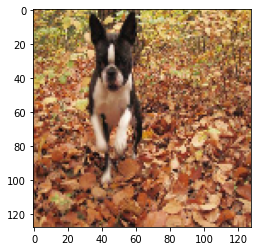

In [18]:
plt.imshow(x_features[0])

In [19]:
x_train_data = np.asarray(x_features,np.float32) / 255
print(x_train_data.shape)

(10222, 128, 128, 3)


In [20]:
#y_train.shape

label_encoder = preprocessing.LabelEncoder()
encodedlabels = label_encoder.fit_transform(y_features)
print('Classes'+str(label_encoder.classes_))
y_train_encoded = np_utils.to_categorical(encodedlabels)
classes = y_train_encoded.shape[1]
print(str(classes))

Classes['affenpinscher' 'afghan_hound' 'african_hunting_dog' 'airedale'
 'american_staffordshire_terrier' 'appenzeller' 'australian_terrier'
 'basenji' 'basset' 'beagle' 'bedlington_terrier' 'bernese_mountain_dog'
 'black-and-tan_coonhound' 'blenheim_spaniel' 'bloodhound' 'bluetick'
 'border_collie' 'border_terrier' 'borzoi' 'boston_bull'
 'bouvier_des_flandres' 'boxer' 'brabancon_griffon' 'briard'
 'brittany_spaniel' 'bull_mastiff' 'cairn' 'cardigan'
 'chesapeake_bay_retriever' 'chihuahua' 'chow' 'clumber' 'cocker_spaniel'
 'collie' 'curly-coated_retriever' 'dandie_dinmont' 'dhole' 'dingo'
 'doberman' 'english_foxhound' 'english_setter' 'english_springer'
 'entlebucher' 'eskimo_dog' 'flat-coated_retriever' 'french_bulldog'
 'german_shepherd' 'german_short-haired_pointer' 'giant_schnauzer'
 'golden_retriever' 'gordon_setter' 'great_dane' 'great_pyrenees'
 'greater_swiss_mountain_dog' 'groenendael' 'ibizan_hound' 'irish_setter'
 'irish_terrier' 'irish_water_spaniel' 'irish_wolfhound'
 '

In [21]:
len(y_train_encoded.shape)
y_train_encoded[0]

2

array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.,
       0.], dtype=float32)

In [0]:
x_train,x_val,y_train,y_val = train_test_split(x_train_data,y_train_encoded,test_size=0.2,random_state=17)

## Model Building

In [0]:
class_count = breed_count.size
IMAGE_DIMS = x_train_data[0].shape
base_model = Sequential()
base_model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=IMAGE_DIMS,activation='relu'))
base_model.add(Conv2D(filters=64,kernel_size=(3,3),padding='same',activation='relu'))
base_model.add(BatchNormalization(axis=3))
base_model.add(Flatten())
base_model.add(Dense(256,activation='relu'))
# Dense layer with 120 neurons as final layer 
base_model.add(Dense(class_count,activation='relu'))

In [24]:
base_model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
base_model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 126, 126, 32)      896       
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 126, 126, 64)      18496     
_________________________________________________________________
batch_normalization (BatchNo (None, 126, 126, 64)      256       
_________________________________________________________________
flatten (Flatten)            (None, 1016064)           0         
_________________________________________________________________
dense (Dense)                (None, 256)               260112640 
_________________________________________________________________
dense_1 (Dense)              (None, 120)               30840     
Total params: 260,163,128
Trainable params: 260,163,000
Non-trainable params: 128
________________________________________

In [25]:
num_epochs = 10
history = base_model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val), verbose=2)

Epoch 1/10
Epoch 2/10
256/256 - 64s - loss: 9.7073 - accuracy: 0.0165 - val_loss: 10.2396 - val_accuracy: 0.0122
Epoch 3/10
256/256 - 64s - loss: 9.1745 - accuracy: 0.0157 - val_loss: 9.3810 - val_accuracy: 0.0127
Epoch 4/10
256/256 - 64s - loss: 8.9659 - accuracy: 0.0229 - val_loss: 10.1923 - val_accuracy: 0.0240
Epoch 5/10
256/256 - 64s - loss: 8.9955 - accuracy: 0.0176 - val_loss: 11.9352 - val_accuracy: 0.0171
Epoch 6/10
256/256 - 64s - loss: 9.0030 - accuracy: 0.0119 - val_loss: 9.1631 - val_accuracy: 0.0103
Epoch 7/10
256/256 - 64s - loss: 8.9317 - accuracy: 0.0132 - val_loss: 9.2491 - val_accuracy: 0.0064
Epoch 8/10
256/256 - 64s - loss: 8.9372 - accuracy: 0.0093 - val_loss: 9.1691 - val_accuracy: 0.0073
Epoch 9/10
256/256 - 65s - loss: 8.9440 - accuracy: 0.0148 - val_loss: 9.2660 - val_accuracy: 0.0147
Epoch 10/10
256/256 - 65s - loss: 8.8974 - accuracy: 0.0196 - val_loss: 9.3135 - val_accuracy: 0.0225


In [26]:
model = Sequential()
model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=IMAGE_DIMS,activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(BatchNormalization(axis=3))

model.add(Conv2D(filters=64,kernel_size=(3,3),input_shape=IMAGE_DIMS,activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))
model.add(BatchNormalization(axis=3))

model.add(Conv2D(filters=128,kernel_size=(3,3),input_shape=IMAGE_DIMS,activation='relu'))
model.add(MaxPooling2D((2,2)))
model.add(Dropout(0.1))

model.add(Flatten())
# Dense layer with 120 neurons as final layer 
model.add(Dense(class_count,activation='relu'))

model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_2 (Conv2D)            (None, 126, 126, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 63, 63, 32)        0         
_________________________________________________________________
dropout (Dropout)            (None, 63, 63, 32)        0         
_________________________________________________________________
batch_normalization_1 (Batch (None, 63, 63, 32)        128       
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 61, 61, 64)        18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 30, 30, 64)        0         
_________________________________________________________________
dropout_1 (Dropout)          (None, 30, 30, 64)       

In [27]:
num_epochs = 10
history = model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val), verbose=2)

Epoch 1/10
256/256 - 11s - loss: 14.8577 - accuracy: 0.0147 - val_loss: 14.8056 - val_accuracy: 0.0147
Epoch 2/10
256/256 - 11s - loss: 14.8476 - accuracy: 0.0179 - val_loss: 14.7609 - val_accuracy: 0.0112
Epoch 3/10
256/256 - 11s - loss: 14.8470 - accuracy: 0.0172 - val_loss: 14.7643 - val_accuracy: 0.0152
Epoch 4/10
256/256 - 11s - loss: 14.8402 - accuracy: 0.0202 - val_loss: 14.7630 - val_accuracy: 0.0220
Epoch 5/10
256/256 - 11s - loss: 14.8345 - accuracy: 0.0218 - val_loss: 14.7746 - val_accuracy: 0.0225
Epoch 6/10
256/256 - 11s - loss: 14.8357 - accuracy: 0.0179 - val_loss: 14.7423 - val_accuracy: 0.0156
Epoch 7/10
256/256 - 11s - loss: 14.8217 - accuracy: 0.0223 - val_loss: 14.8048 - val_accuracy: 0.0230
Epoch 8/10
256/256 - 11s - loss: 14.8374 - accuracy: 0.0273 - val_loss: 14.8623 - val_accuracy: 0.0240
Epoch 9/10
256/256 - 11s - loss: 14.8473 - accuracy: 0.0196 - val_loss: 14.7661 - val_accuracy: 0.0176
Epoch 10/10
256/256 - 11s - loss: 14.8209 - accuracy: 0.0245 - val_loss: 

In [0]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
def create_model(ALPHA=1,trainable=True):
  model = MobileNet(input_shape=IMAGE_DIMS, include_top=False, alpha=1.0,weights="imagenet")
  for layer in model.layers:
        layer.trainable = trainable
  
  input_layer = Input(shape=(128,128,3),name = 'image_input')
  output_base_model = model(input_layer)
  transfer_learn_model=GlobalAveragePooling2D()(output_base_model)
    #transfer_learn_model = Flatten()(output_base_model)
    #transfer_learn_model = Dense(1024, activation='relu')(output_base_model)
  transfer_learn_model = Dense(256, activation='relu')(transfer_learn_model)
  transfer_learn_model=  Dropout(0.2)(transfer_learn_model)
  transfer_learn_model = BatchNormalization()(transfer_learn_model)
  transfer_learn_model = Dense(class_count, activation='softmax', name='predictions',kernel_initializer='uniform')(transfer_learn_model)
  final_model = Model(inputs=input_layer, outputs=transfer_learn_model)
  return final_model

In [29]:
mobileNet_model = create_model(False)
mobileNet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mobileNet_model.summary()

17227776/17225924 [==============================] - 0s 0us/step
Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d (Gl (None, 1024)              0         
_________________________________________________________________
dense_3 (Dense)              (None, 256)               262400    
_________________________________________________________________
dropout_3 (Dropout)          (None, 256)               0         
_________________________________________________________________
batch_normalization_3 (Batch (None, 256)               1024      
______________________________________________________________

In [0]:
# SETTING UP CHECKPOINTS, CALLBACKS AND REDUCING LEARNING RATE
lrr = ReduceLROnPlateau(monitor='val_accuracy', 
                        patience=3, 
                        verbose=2, 
                        factor=0.4, 
                        min_lr=0.00001)

filepath="weights.best_{epoch:02d}-{val_accuracy:.2f}.hdf5"
checkpoints = ModelCheckpoint(filepath, monitor='val_accuracy', 
                              verbose=2, save_best_only=True, mode='max')
callbacks_list = [checkpoints, lrr]

In [31]:
num_epochs = 10
history = mobileNet_model.fit(x_train, y_train, epochs=num_epochs, validation_data=(x_val, y_val), verbose=2 , callbacks=callbacks_list)

Epoch 1/10

Epoch 00001: val_accuracy improved from -inf to 0.20489, saving model to weights.best_01-0.20.hdf5
256/256 - 28s - loss: 3.2354 - accuracy: 0.2490 - val_loss: 3.1446 - val_accuracy: 0.2049 - lr: 0.0010
Epoch 2/10

Epoch 00002: val_accuracy improved from 0.20489 to 0.34474, saving model to weights.best_02-0.34.hdf5
256/256 - 27s - loss: 2.0284 - accuracy: 0.4535 - val_loss: 2.4701 - val_accuracy: 0.3447 - lr: 0.0010
Epoch 3/10

Epoch 00003: val_accuracy did not improve from 0.34474
256/256 - 27s - loss: 1.5069 - accuracy: 0.5632 - val_loss: 2.8907 - val_accuracy: 0.2738 - lr: 0.0010
Epoch 4/10

Epoch 00004: val_accuracy did not improve from 0.34474
256/256 - 27s - loss: 1.0961 - accuracy: 0.6738 - val_loss: 2.8972 - val_accuracy: 0.2914 - lr: 0.0010
Epoch 5/10

Epoch 00005: val_accuracy did not improve from 0.34474

Epoch 00005: ReduceLROnPlateau reducing learning rate to 0.0004000000189989805.
256/256 - 27s - loss: 0.8413 - accuracy: 0.7399 - val_loss: 2.9355 - val_accuracy

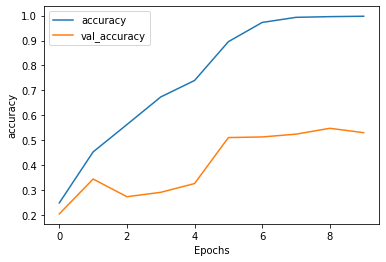

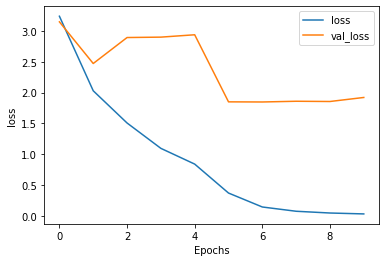

In [32]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Model is till poor , Using data Augmentation to fenerate more images to improve performance

In [0]:
EPOCHS=15
BATCH_SIZE=125

In [38]:
ALPHA = 1.0 # Width hyper parameter for MobileNet (0.25, 0.5, 0.75, 1.0). Higher width means more accurate but slower
def create_model_augmented(ALPHA=1,trainable=False):
  model = MobileNet(input_shape=IMAGE_DIMS, include_top=False, alpha=1.0,weights="imagenet")
  for layer in model.layers:
        layer.trainable = trainable
  
  input_layer = Input(shape=(128,128,3),name = 'image_input')
  output_base_model = model(input_layer)
  transfer_learn_model=GlobalAveragePooling2D()(output_base_model)
  #transfer_learn_model = Flatten()(output_base_model)
  transfer_learn_model = Dense(1024, activation='relu')(transfer_learn_model)
  transfer_learn_model=  Dropout(0.2)(transfer_learn_model)
  #transfer_learn_model = BatchNormalization()(transfer_learn_model)
  transfer_learn_model = Dense(class_count, activation='softmax', name='predictions',kernel_initializer='uniform')(transfer_learn_model)
  final_model = Model(inputs=input_layer, outputs=transfer_learn_model)
  return final_model

mobileNet_model = create_model_augmented(False)
mobileNet_model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])
mobileNet_model.summary()

Model: "model_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
image_input (InputLayer)     [(None, 128, 128, 3)]     0         
_________________________________________________________________
mobilenet_1.00_128 (Model)   (None, 4, 4, 1024)        3228864   
_________________________________________________________________
global_average_pooling2d_1 ( (None, 1024)              0         
_________________________________________________________________
dense_4 (Dense)              (None, 1024)              1049600   
_________________________________________________________________
dropout_5 (Dropout)          (None, 1024)              0         
_________________________________________________________________
predictions (Dense)          (None, 120)               123000    
Total params: 4,401,464
Trainable params: 1,172,600
Non-trainable params: 3,228,864
_________________________________________

In [0]:
train_generator = ImageDataGenerator(rotation_range=90, width_shift_range=0.1,
                     height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                     horizontal_flip=True, fill_mode="nearest")
train_generator.fit(x_train)
val_generator = ImageDataGenerator(rotation_range=90, width_shift_range=0.1,
                height_shift_range=0.1, shear_range=0.2, zoom_range=0.2,
                horizontal_flip=True, fill_mode="nearest")
val_generator.fit(x_val)

In [41]:
history = mobileNet_model.fit_generator(train_generator.flow(x_train, y_train, batch_size=BATCH_SIZE), steps_per_epoch=len(x_train) / BATCH_SIZE, 
                    epochs=EPOCHS, validation_data=val_generator.flow(x_val, y_val, batch_size=BATCH_SIZE), callbacks=callbacks_list)

Epoch 1/15
66/65 [==============================] - ETA: 0s - loss: 3.7072 - accuracy: 0.1674
Epoch 00001: val_accuracy did not improve from 0.54817
66/65 [==============================] - 44s 662ms/step - loss: 3.7072 - accuracy: 0.1674 - val_loss: 2.6823 - val_accuracy: 0.3159 - lr: 0.0010
Epoch 2/15
66/65 [==============================] - ETA: 0s - loss: 2.3835 - accuracy: 0.3770
Epoch 00002: val_accuracy did not improve from 0.54817
66/65 [==============================] - 43s 652ms/step - loss: 2.3835 - accuracy: 0.3770 - val_loss: 2.3533 - val_accuracy: 0.3785 - lr: 0.0010
Epoch 3/15
66/65 [==============================] - ETA: 0s - loss: 2.0247 - accuracy: 0.4633
Epoch 00003: val_accuracy did not improve from 0.54817
66/65 [==============================] - 43s 649ms/step - loss: 2.0247 - accuracy: 0.4633 - val_loss: 2.2163 - val_accuracy: 0.4137 - lr: 0.0010
Epoch 4/15
66/65 [==============================] - ETA: 0s - loss: 1.8551 - accuracy: 0.4931
Epoch 00004: val_accurac

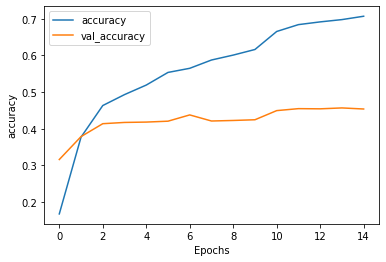

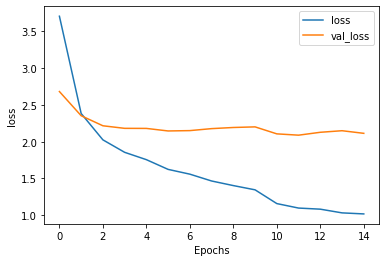

In [42]:
import matplotlib.pyplot as plt


def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_'+string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_'+string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

### Model is still Underfit